In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import variational
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import wandb

from thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss
from thirdparty.repdistiller.distiller_zoo import PKT, ABLoss, FactorTransfer, KDSVD, FSP, NSTLoss

from thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bcu_distill, validate
from thirdparty.repdistiller.helper.pretrain import init

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def pdb():
    import pdb
    pdb.set_trace

In [4]:
def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')

In [5]:
def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

In [6]:
def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

In [7]:
### Activations along the path
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import datasets

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

def entropy(p, dim = -1, keepdim = False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)
    #return (p * p.log()).sum(dim=dim, keepdim=keepdim)

def collect_prob(data_loader, model):
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=False, num_samples=4000)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, sampler=sampler, shuffle=False)
    prob = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(data_loader_small, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            data, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):    
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)
    
    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])
    
    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])    
    return X_f, Y_f, X_r, Y_r

def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    #clf = SVC(C=3,gamma='auto',kernel='rbf')
    clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial')
    clf.fit(X_r, Y_r)
    results = clf.predict(X_f)
    results1 = clf.predict(X_r)
    acc = accuracy_score(results, Y_f)
    train_ac = accuracy_score(results1, Y_r)
    TP, FP, TN, FN = perf_measure(Y_r, results1)
    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    
    print (f"TP:{TP}, FP{FP}, TN{TN}, FN{FN}")
    print (f"false negative rate: {FN/(FN+TP)}")
    print (f"false positive rate: {FP/(FP+TN)}")
    return acc, train_acc, FPR, FNR #results.mean(), results1.mean()
    
def plot_entropy_dist(model,retain_loader,forget_loader,test_loader_full, title, ax):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.ticker import FuncFormatter
    #train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, batch_size=100, seed=0, augment=False, shuffle=False)
    #indexes = np.flatnonzero(np.array(train_loader_full.dataset.targets) == class_to_forget)
    #replaced = np.random.RandomState(0).choice(indexes, size=100 if num_to_forget==100 else len(indexes), replace=False)
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader,forget_loader,test_loader_full, model)
    #np.savetxt('retain_prob.txt', X_r[Y_r==1])
    #np.savetxt('forget_prob.txt', X_f)
    #np.savetxt('test_prob.txt', X_r[Y_r==0])
    sns.distplot(np.log(X_r[Y_r==1]).reshape(-1), kde=False, norm_hist=True, rug=False, label='retain', ax=plt)
    sns.distplot(np.log(X_r[Y_r==0]).reshape(-1), kde=False, norm_hist=True, rug=False, label='test', ax=plt)
    sns.distplot(np.log(X_f).reshape(-1), kde=False, norm_hist=True, rug=False, label='forget', ax=plt)
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title(title,size=18)
    plt.xlabel('Log of Entropy',size=14)
    plt.show()
    plt.clf()


def membership_attack(retain_loader,forget_loader,test_loader,model, name):
    prob, train_acc, FPR, FNR = get_membership_attack_prob(retain_loader,forget_loader,test_loader,model)
    print("Attack prob: ", prob)
    return prob

In [8]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=512, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=512, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [9]:
def activations_predictions(model,dataloader,name):
    criterion = torch.nn.CrossEntropyLoss()
    metrics=get_metrics(model,dataloader,criterion,False)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']
    return _,_

In [10]:
def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist

In [11]:
def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

In [12]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [13]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [14]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        #run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)

def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=epoch, ignore_index=None, quiet=True)

In [15]:
def readout_retrain(model, data_loader, test_loader, lr=0.1, epochs=500, threshold=0.01, quiet=True):
    torch.manual_seed(seed)
    model = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=True, num_samples=500)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=sampler, num_workers=data_loader.num_workers)
    metrics = []
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        metrics.append(run_train_epoch(model, model_init, test_loader, loss_fn, optimizer, split='test', epoch=epoch, ignore_index=None, quiet=quiet))
        if metrics[-1]['loss'] <= threshold:
            break
        run_train_epoch(model, model_init, data_loader_small, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
    return epoch, metrics

def extract_retrain_time(metrics, threshold=0.1):
    losses = np.array([m['loss'] for m in metrics])
    return np.argmax(losses < threshold)

def all_readouts(model,thresh=0.1,name='method'):
    train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=args.batch_size, shuffle=True)
    retrain_time, _ = readout_retrain(model, train_loader, forget_loader, epochs=100, lr=0.01, threshold=thresh)
    test_error = test(model, test_loader_full)['error']
    forget_error = test(model, forget_loader)['error']
    retain_error = test(model, retain_loader)['error']
    print(f"{name} ->"
          f"\tFull test error: {test_error:.2%}"
          f"\tForget error: {forget_error:.2%}\tRetain error: {retain_error:.2%}"
          f"\tFine-tune time: {retrain_time+1} steps")
    #print(f"{name} ->"
    #      f"\tFine-tune time: {retrain_time+1} steps")
    log_dict[f"{name}_retrain_time"]=retrain_time+1
    return(dict(test_error=test_error, forget_error=forget_error, retain_error=retain_error, retrain_time=retrain_time))

In [16]:
def test_activations(model_scrubf, modelf0, delta_w_s, delta_w_m0, data_loader, \
                    loss_fn=nn.CrossEntropyLoss(),\
                    optimizer=torch.optim.SGD, \
                    seed=1,quiet=False):

    model_scrubf.eval()
    modelf0.eval()
    
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)

    
    metrics = AverageMeter()    
    num_classes = data_loader.dataset.targets.max().item() + 1
    
    for idx, batch in enumerate(tqdm(data_loader, leave=False)):
        batch = [tensor.to(next(model_scrubf.parameters()).device) for tensor in batch]
        input, target = batch
        
        output_sf = model_scrubf(input)
        G_sf = []

        for cls in range(num_classes):
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=True)
            grads = torch.cat([g.view(-1) for g in grads])
            G_sf.append(grads)

        grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            
        G_sf = torch.stack(G_sf)#.pow(2)
        delta_f_sf_update = torch.matmul(G_sf,delta_w_s.sqrt()*torch.empty_like(delta_w_s).normal_())
        G_sf = G_sf.pow(2)
        delta_f_sf = torch.matmul(G_sf,delta_w_s)

        output_m0 = modelf0(input)
        G_m0 = []

        for cls in range(num_classes):
            grads = torch.autograd.grad(output_m0[0,cls],modelf0.parameters(),retain_graph=True)
            grad_m0 = torch.cat([g.view(-1) for g in grads])
            G_m0.append(grad_m0)

        grads = torch.autograd.grad(output_m0[0,cls],modelf0.parameters(),retain_graph=False)
            
        G_m0 = torch.stack(G_m0).pow(2)
        delta_f_m0 = torch.matmul(G_m0,delta_w_m0)
        
        kl = ((output_m0 - output_sf).pow(2)/delta_f_m0 + delta_f_sf/delta_f_m0 - torch.log(delta_f_sf/delta_f_m0) - 1).sum()
        
        torch.manual_seed(seed)
        output_sf += delta_f_sf_update#delta_f_sf.sqrt()*torch.empty_like(delta_f_sf).normal_()
        
        loss = loss_fn(output_sf, target)
        metrics.update(n=input.size(0), loss=loss.item(), error=get_error(output_sf, target), kl=kl.item())
    
    return metrics.avg

In [17]:
import torch
torch.cuda.is_available()

True

### Pre-training

In [18]:
%run main.py --dataset lacuna100 --dataroot=data/lacuna100 --model resnet --filters 1.0 --lr 0.1 --lossfn ce --num-classes 100

Checkpoint name: lacuna100_resnet_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in lacuna100_resnet_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_training]
confuse mode: False
split mode: None
Number of Classes: 100
[0] train metrics:{"loss": 3.987484888076782, "error": 0.923}
Learning Rate : 0.1
[0] dry_run metrics:{"loss": 3.395326801300049, "error": 0.83653125}
Learning Rate : 0.1
[0] test metrics:{"loss": 3.4219942169189452, "error": 0.8447}
Learning Rate : 0.1
Epoch Time: 10.8 sec
[1] train metrics:{"loss": 3.1922737522125244, "error": 0.78334375}
Learning Rate : 0.1
Epoch Time: 5.56 sec
[2] train metrics:{"loss": 2.6385717277526854, "error": 0.63821875}
Learning Rate : 0.1
Epoch Time: 5.53 sec
[3] train metrics:{"loss": 2.220917667865753, "error": 0.51859375}
Learning Rate : 0.1
Epoch Time: 5.45 sec
[4] train metrics:{"loss": 1.9556603002548218, "error": 0.41671875}
Learning Rate : 0.1
Epoch Time: 5.41 sec
[5] train metrics:{"loss": 1.722495491027832, "erro

### Train the original model

In [19]:
%run main_merged.py --dataset lacuna10 --model resnet --dataroot=data/lacuna10/ --filters 1.0 --lr 0.01 \
--resume checkpoints/lacuna100_resnet_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 5e-4 --batch-size 128 --epochs 26 --seed 1

Checkpoint name: lacuna10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in lacuna10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_training]
confuse mode: False
split mode: train
Number of Classes: 10
Epoch: [0][0/25]	Time 0.045 (0.045)	Data 0.007 (0.007)	Loss 0.8869 (0.8869)	Acc@1 87.500 (87.500)	Acc@5 99.219 (99.219)
 * Acc@1 90.781 Acc@5 99.000
[0] test metrics:{"loss": 0.20946366262435914, "error": 0.055999995708465575}
Learning Rate : 0.01
Epoch Time: 0.62 sec
Epoch: [1][0/25]	Time 0.015 (0.015)	Data 0.008 (0.008)	Loss 0.1985 (0.1985)	Acc@1 92.969 (92.969)	Acc@5 100.000 (100.000)
 * Acc@1 95.500 Acc@5 99.750
Epoch Time: 0.42 sec
Epoch: [2][0/25]	Time 0.013 (0.013)	Data 0.007 (0.007)	Loss 0.0561 (0.0561)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 98.250 Acc@5 99.969
Epoch Time: 0.41 sec
Epoch: [3][0/25]	Time 0.013 (0.013)	Data 0.006 (0.006)	Loss 0.0369 (0.0369)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.469 Acc@5 100.

### Retrain Forgetting

In [20]:
%run main_merged.py --dataset lacuna10 --model resnet --dataroot=data/lacuna10/ --filters 1 --lr 0.01 \
--resume checkpoints/lacuna100_resnet_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 5e-4 --batch-size 128 --epochs 26 \
--forget-class 5 --seed 1

Checkpoint name: lacuna10_resnet_1_0_forget_[5]_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in lacuna10_resnet_1_0_forget_[5]_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_training]
confuse mode: False
split mode: train
Number of Classes: 10
Epoch: [0][0/25]	Time 0.016 (0.016)	Data 0.007 (0.007)	Loss 0.9343 (0.9343)	Acc@1 82.812 (82.812)	Acc@5 99.219 (99.219)
 * Acc@1 90.469 Acc@5 98.969
[0] test metrics:{"loss": 0.18473745082737877, "error": 0.052222222222222225}
Learning Rate : 0.01
Epoch Time: 0.59 sec
Epoch: [1][0/25]	Time 0.015 (0.015)	Data 0.006 (0.006)	Loss 0.1682 (0.1682)	Acc@1 94.531 (94.531)	Acc@5 100.000 (100.000)
 * Acc@1 96.250 Acc@5 99.812
Epoch Time: 0.42 sec
Epoch: [2][0/25]	Time 0.014 (0.014)	Data 0.007 (0.007)	Loss 0.0502 (0.0502)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 98.719 Acc@5 99.969
Epoch Time: 0.42 sec
Epoch: [3][0/25]	Time 0.014 (0.014)	Data 0.007 (0.007)	Loss 0.0285 (0.0285)	Acc@1 99.219 (99.219)	Acc@5 100.000 (100.000)
 * Acc@1 99.531 Acc@5 100.

#### Logs

In [21]:
log_dict={}
training_epochs=25

In [22]:
log_dict['epoch']=training_epochs

In [23]:
parameter_count(copy.deepcopy(model))

Total Number of Parameters: 11175178


### Loads checkpoints

In [24]:
import copy
model0 = copy.deepcopy(model)

arch = args.model 
filters=args.filters
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args.dataset
class_to_forget = args.forget_class
init_checkpoint = f"checkpoints/{args.name}_init.pt"
num_classes=args.num_classes
num_to_forget = args.num_to_forget
num_total = len(train_loader.dataset)
num_to_retain = num_total - 4000#num_to_forget
seed = args.seed
unfreeze_start = None

learningrate=f"lr_{str(args.lr).replace('.','_')}"
batch_size=f"_bs_{str(args.batch_size)}"
lossfn=f"_ls_{args.lossfn}"
wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
seed_name=f"_seed_{args.seed}_"

num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'

m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

model.load_state_dict(torch.load(m_name))
model0.load_state_dict(torch.load(m0_name))


model.cuda()
model0.cuda()


for p in model.parameters():
    p.data0 = p.data.clone()
for p in model0.parameters():
    p.data0 = p.data.clone()

teacher = copy.deepcopy(model)
student = copy.deepcopy(model)

#### Data Loader

In [25]:
train_loader_full, valid_loader_full, test_loader_full   = datasets.get_loaders(dataset, batch_size=args.batch_size, seed=seed, root=args.dataroot, augment=False, shuffle=True)
marked_loader, _, _  = datasets.get_loaders(dataset, class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, root=args.dataroot, augment=False, shuffle=True)

def replace_loader_dataset(data_loader, dataset, batch_size=args.batch_size, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)
    
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=512, seed=seed, shuffle=True)

retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=256, seed=seed, shuffle=True)


assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

confuse mode: False
split mode: train
confuse mode: False
split mode: train


In [26]:
log_dict['args']=args

In [27]:
print (len(forget_loader.dataset))
print (len(retain_loader.dataset))
print (len(test_loader_full.dataset))
print (len(train_loader_full.dataset))
from collections import Counter
print(dict(Counter(train_loader_full.dataset.targets)))

320
2880
1000
3200
{0: 320, 1: 320, 2: 320, 3: 320, 4: 320, 5: 320, 6: 320, 7: 320, 8: 320, 9: 320}


## SCRUB Forgetting

In [28]:
args.optim = 'sgd'
args.gamma = 0.99
args.alpha = 0.95
args.beta = 0.9
args.smoothing = 0.0
args.msteps = 5
args.clip = 0.2
args.sstart = 5
args.kd_T = 4
args.distill = 'kd'

args.sgda_batch_size = 128
args.del_batch_size = 128
args.sgda_epochs = 3
args.sgda_learning_rate = 0.005
args.lr_decay_epochs = [3,5,9]
args.lr_decay_rate = 0.1
args.sgda_weight_decay = 5e-4
args.sgda_momentum = 0.9

In [29]:
model_t = copy.deepcopy(teacher)
model_s = copy.deepcopy(student)

In [30]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s, avg_fn=avg_fn)

In [31]:
module_list = nn.ModuleList([])
module_list.append(model_s)
trainable_list = nn.ModuleList([])
trainable_list.append(model_s)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(args.kd_T)
criterion_kd = DistillKL(args.kd_T)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

# optimizer
if args.optim == "sgd":
    optimizer = optim.SGD(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "adam": 
    optimizer = optim.Adam(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "rmsp":
    optimizer = optim.RMSprop(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)

In [32]:
module_list.append(model_t)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True
    swa_model.cuda()

In [33]:
acc_rs = []
acc_fs = []
acc_ts = []
acc_vs = []
for epoch in range(1, args.sgda_epochs + 1):

    lr = sgda_adjust_learning_rate(epoch, args, optimizer)

    print("==> SCRUB unlearning ...")

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True, prefix="train_lacuna10_resnet")
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True, prefix="forget_lacuna10_resnet")
    acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())

    maximize_loss = 0
    if epoch <= args.msteps:
        maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    train_acc, train_loss = train_distill(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer, args, "minimize")
    if epoch >= args.sstart:
        swa_model.update_parameters(model_s)

    
    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
acc_rs.append(100-acc_r.item())
acc_fs.append(100-acc_f.item())
acc_vs.append(100-acc_v.item())

==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 100.000 
maximize loss: -17.97	 minimize loss: 0.32	 train_acc: 100.0
==> SCRUB unlearning ...
 * Acc@1 100.000 
maximize loss: -48.26	 minimize loss: 1.73	 train_acc: 100.0
==> SCRUB unlearning ...
 * Acc@1 99.826 
maximize loss: -112.02	 minimize loss: 7.60	 train_acc: 99.8263931274414


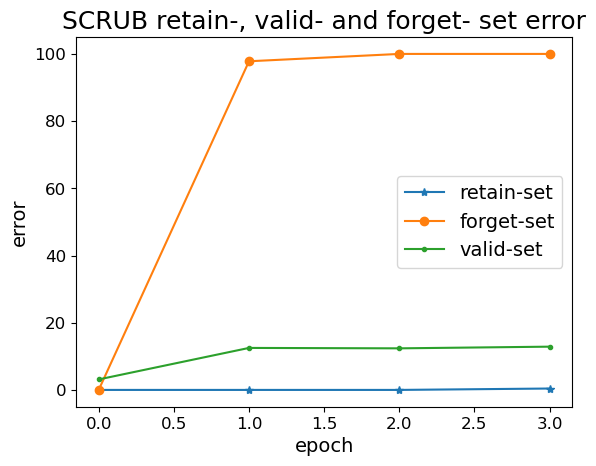

In [34]:
from matplotlib import pyplot as plt
indices = list(range(0,len(acc_rs)))
plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
plt.legend(prop={'size': 14})
plt.tick_params(labelsize=12)
plt.title('SCRUB retain-, valid- and forget- set error',size=18)
plt.xlabel('epoch',size=14)
plt.ylabel('error',size=14)
plt.show()

### Original

In [35]:
m_D_r_activations,m_D_r_predictions=activations_predictions(copy.deepcopy(model),copy.deepcopy(retain_loader),'Original_Model_D_r')
m_D_f_activations,m_D_f_predictions=activations_predictions(copy.deepcopy(model),copy.deepcopy(forget_loader),'Original_Model_D_f')
m_D_t_activations,m_D_t_predictions=activations_predictions(copy.deepcopy(model),copy.deepcopy(test_loader_full),'Original_Model_D_t')

Original_Model_D_r -> Loss:0.001, Error:0.0
Original_Model_D_f -> Loss:0.001, Error:0.0
Original_Model_D_t -> Loss:0.114, Error:0.028


### Retrain

In [36]:
m0_D_r_activations,m0_D_r_predictions=activations_predictions(copy.deepcopy(model0),copy.deepcopy(retain_loader),'Retrain_Model_D_r')
m0_D_f_activations,m0_D_f_predictions=activations_predictions(copy.deepcopy(model0),copy.deepcopy(forget_loader),'Retrain_Model_D_f')
m0_D_t_activations,m0_D_t_predictions=activations_predictions(copy.deepcopy(model0),copy.deepcopy(test_loader_full),'Retrain_Model_D_t')

Retrain_Model_D_r -> Loss:0.001, Error:0.0
Retrain_Model_D_f -> Loss:6.019, Error:1.0
Retrain_Model_D_t -> Loss:0.65, Error:0.121


### SCRUB

In [37]:
ntk_D_r_activations,ntk_D_r_predictions=activations_predictions(copy.deepcopy(model_s),copy.deepcopy(retain_loader),'SCRUB_D_r')
ntk_D_f_activations,ntk_D_f_predictions=activations_predictions(copy.deepcopy(model_s),copy.deepcopy(forget_loader),'SCRUB_D_f')
ntk_D_t_activations,ntk_D_t_predictions=activations_predictions(copy.deepcopy(model_s),copy.deepcopy(test_loader_full),'SCRUB_D_t')

SCRUB_D_r -> Loss:0.018, Error:0.004166666666666667
SCRUB_D_f -> Loss:75.35, Error:1.0
SCRUB_D_t -> Loss:7.592, Error:0.129


# Fisher Forgetting

# Fisher

In [38]:
modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [39]:
def hessian(dataset, model):
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(args.device), orig_target.to(args.device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2)
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [40]:
hessian(retain_loader.dataset, modelf)
#hessian(retain_loader.dataset, modelf0)

100%|██████████| 2880/2880 [03:09<00:00, 15.18it/s]


In [41]:
def get_mean_var(p, is_base_dist=False, alpha=3e-6):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3)
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    if not is_base_dist:
        mu = copy.deepcopy(p.data0.clone())
    else:
        mu = copy.deepcopy(p.data0.clone())
    if p.size(0) == num_classes and num_to_forget is None:
        mu[class_to_forget] = 0
        var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

In [42]:
fisher_dir = []
alpha = 1e-7
torch.manual_seed(seed)
for i, p in enumerate(modelf.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()
    fisher_dir.append(var.sqrt().view(-1).cpu().detach().numpy())

## Fisher Noise in Weights

In [43]:
fisher_D_r_activations,fisher_D_r_predictions=activations_predictions(copy.deepcopy(modelf),copy.deepcopy(retain_loader),'Fisher_D_r')
fisher_D_f_activations,fisher_D_f_predictions=activations_predictions(copy.deepcopy(modelf),copy.deepcopy(forget_loader),'Fisher_D_f')
fisher_D_t_activations,fisher_D_t_predictions=activations_predictions(copy.deepcopy(modelf),copy.deepcopy(test_loader_full),'Fisher_D_t')

Fisher_D_r -> Loss:0.005, Error:0.0
Fisher_D_f -> Loss:3.554, Error:0.9875
Fisher_D_t -> Loss:0.451, Error:0.12


### Information in the Activations

### Finetune

In [44]:
model_ft = copy.deepcopy(model)
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.batch_size, shuffle=True)    
finetune(model_ft, retain_loader, epochs=10, quiet=True, lr=0.01)

Epoch: [0][0/23]	Time 0.040 (0.040)	Data 0.014 (0.014)	Loss 0.0015 (0.0015)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch: [1][0/23]	Time 0.014 (0.014)	Data 0.007 (0.007)	Loss 0.0021 (0.0021)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch: [2][0/23]	Time 0.017 (0.017)	Data 0.007 (0.007)	Loss 0.0014 (0.0014)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch: [3][0/23]	Time 0.016 (0.016)	Data 0.007 (0.007)	Loss 0.0021 (0.0021)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch: [4][0/23]	Time 0.015 (0.015)	Data 0.007 (0.007)	Loss 0.0036 (0.0036)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch: [5][0/23]	Time 0.015 (0.015)	Data 0.006 (0.006)	Loss 0.0020 (0.0020)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch: [6][0/23]	Time 0.016 (0.016)	Data 0.007 (0.007)	Loss 0.0014 (0.

In [45]:
finetune_D_r_activations,finetune_D_r_predictions=activations_predictions(copy.deepcopy(model_ft),copy.deepcopy(retain_loader),'Finetune_D_r')
finetune_D_f_activations,finetune_D_f_predictions=activations_predictions(copy.deepcopy(model_ft),copy.deepcopy(forget_loader),'Finetune_D_f')
finetune_D_t_activations,finetune_D_t_predictions=activations_predictions(copy.deepcopy(model_ft),copy.deepcopy(test_loader_full),'Finetune_D_t')

Finetune_D_r -> Loss:0.001, Error:0.0
Finetune_D_f -> Loss:0.0, Error:0.0
Finetune_D_t -> Loss:0.105, Error:0.026


### Readouts

In [46]:
try: readouts
except: readouts = {}

thresh=log_dict['Original_Model_D_f_loss']+1e-5
print(thresh)
readouts["e"] = all_readouts(copy.deepcopy(model),thresh,'Original')
readouts["a"] = all_readouts(copy.deepcopy(model_ft),thresh,'Finetune')
readouts["b"] = all_readouts(copy.deepcopy(modelf),thresh,'Fisher')
readouts["d"] = all_readouts(copy.deepcopy(model0),thresh,'Retrain')
readouts["d"] = all_readouts(copy.deepcopy(model_s),thresh,'SCRUB')

0.0008431148333053706


Original ->	Full test error: 2.80%	Forget error: 0.00%	Retain error: 0.00%	Fine-tune time: 1 steps


Finetune ->	Full test error: 2.60%	Forget error: 0.00%	Retain error: 0.00%	Fine-tune time: 1 steps


Fisher ->	Full test error: 12.00%	Forget error: 98.75%	Retain error: 0.00%	Fine-tune time: 100 steps


Retrain ->	Full test error: 12.10%	Forget error: 100.00%	Retain error: 0.00%	Fine-tune time: 100 steps


SCRUB ->	Full test error: 12.90%	Forget error: 100.00%	Retain error: 0.42%	Fine-tune time: 100 steps


# Save Dictionary

/tmp/ipykernel_2422/2828292684.py:82: UserWarning:  

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(X_r[Y_r==1]).reshape(-1), kde=False, norm_hist=True, rug=False, label='retain', ax=plt)
/tmp/ipykernel_2422/2828292684.py:83: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(X_r[Y_r==0]).reshape(-1),

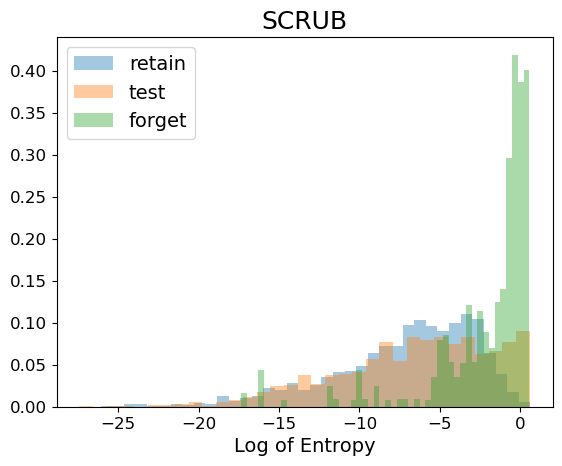

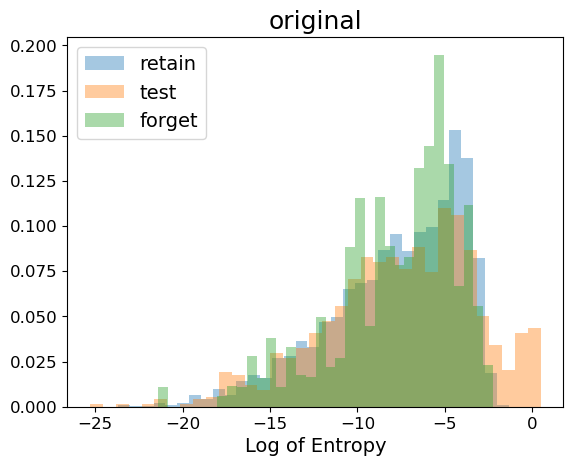

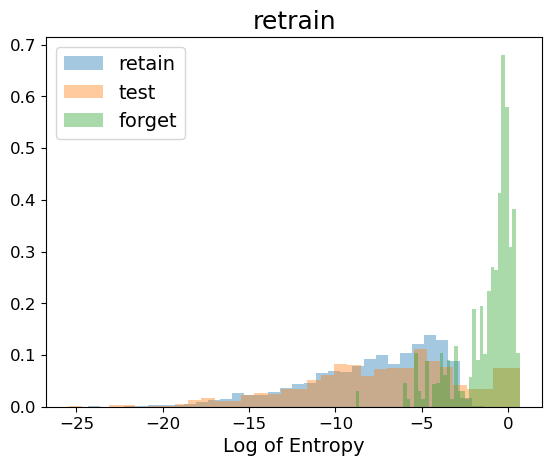

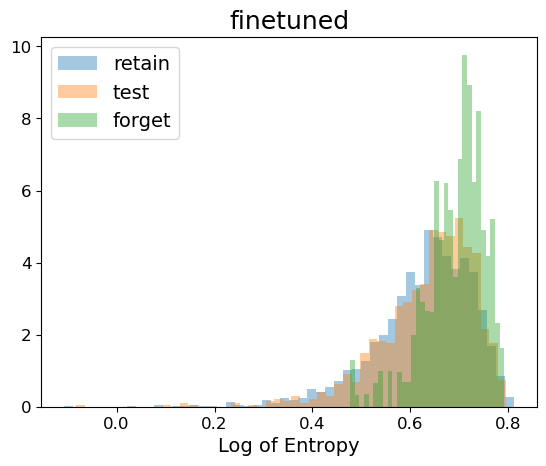

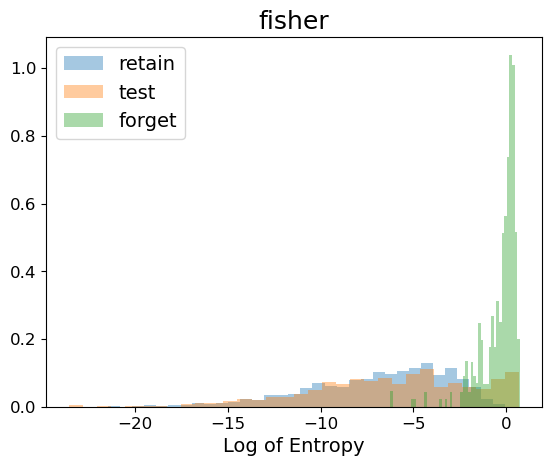

<Figure size 640x480 with 0 Axes>

In [47]:
#fig, ax = plt.subplots(5,1,figsize=(9,20))
ax = [0,0,0,0,0]
plot_entropy_dist(copy.deepcopy(model_s),retain_loader,forget_loader,test_loader_full, 'SCRUB',ax[4])
plot_entropy_dist(copy.deepcopy(model),retain_loader,forget_loader,test_loader_full, 'original', ax[0])
plot_entropy_dist(copy.deepcopy(model0),retain_loader,forget_loader,test_loader_full, 'retrain', ax[1])
plot_entropy_dist(copy.deepcopy(model_ft),retain_loader,forget_loader,test_loader_full, 'finetuned',ax[2])
plot_entropy_dist(copy.deepcopy(modelf),retain_loader,forget_loader,test_loader_full, 'fisher',ax[3])